# FML Homework 4 - Erin Choi

## Data Preprocessing

In [1]:
# import packages - general
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython import display
from sklearn import metrics, model_selection, tree, utils

# preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split

# evaluation
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve, precision_recall_curve
from sklearn.metrics import mean_squared_error

# for perceptron
from sklearn.linear_model import Perceptron

# for NNs
import random
import torch
from torch import nn, optim
import math

In [2]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [3]:
# preprocess data in pandas
data = pd.read_csv('diabetes.csv', encoding='utf-8')

# change biologicalsex to 0/1 rather than 1/2 binary
data.loc[(data['BiologicalSex']==2, 'BiologicalSex')] = 0

# drop zodiac
data.drop(columns=['Zodiac'], inplace=True)
    
data.head()

,Diabetes,HighBP,HighChol,BMI,Smoker,Stroke,Myocardial,PhysActivity,Fruit,Vegetables,...,HasHealthcare,NotAbleToAffordDoctor,GeneralHealth,MentalHealth,PhysicalHealth,HardToClimbStairs,BiologicalSex,AgeBracket,EducationBracket,IncomeBracket
0,0,1,1,40,1,0,0,0,0,1,...,1,0,5,18,15,1,1,9,4,3
1,0,0,0,25,1,0,0,1,0,0,...,0,1,3,0,0,0,1,7,6,1
2,0,1,1,28,0,0,0,0,1,0,...,1,1,5,30,30,1,1,9,4,8
3,0,1,0,27,0,0,0,1,1,1,...,1,0,2,0,0,0,1,11,3,6
4,0,1,1,24,0,0,0,1,1,1,...,1,0,2,3,0,0,1,11,5,4


In [158]:
data.shape

(253680, 21)

In [118]:
# separate features from target
dataX = data.copy().drop(columns=['Diabetes'])
dataY = pd.DataFrame(data.copy()['Diabetes'])

In [119]:
# split data into train/test sets using StratifiedShuffleSplit
# to make sure sets have the same proportion of diabetes classes
split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state=42)
for train_index, test_index in split.split(dataX, dataY):
    xTrain = dataX.loc[train_index]
    yTrain = dataY.loc[train_index]
    xTest = dataX.loc[test_index]
    yTest = dataY.loc[test_index]
    
print(xTrain.shape, xTest.shape, yTrain.shape, yTest.shape)

(202944, 20) (50736, 20) (202944, 1) (50736, 1)


In [120]:
# scale continuous & ordinal features using MinMaxScaler
# so they're between 0 and 1 (as binary variables are 0/1)
# scaling happens after the train/test split to prevent data leakage

contord = ['GeneralHealth', 'AgeBracket', 'EducationBracket', 'IncomeBracket',
                     'BMI', 'MentalHealth', 'PhysicalHealth']

scaler = MinMaxScaler()
xTrain_scaled = scaler.fit_transform(pd.DataFrame(xTrain[contord]))
for i in range(len(contord)):
    xTrain[contord[i]] = xTrain_scaled[:,i]
    
xTest_scaled = scaler.transform(pd.DataFrame(xTest[contord]))
for i in range(len(contord)):
    xTest[contord[i]] = xTest_scaled[:,i]

In [121]:
# turn dfs to numpy arrays, turn arrays into tensors
xTrainT = torch.tensor(np.array(xTrain), dtype=torch.float32)
xTestT = torch.tensor(np.array(xTest), dtype=torch.float32)
yTrainT = torch.flatten(torch.tensor(np.array(yTrain), dtype=torch.float32))
yTrainT = yTrainT.long()
yTestT = torch.flatten(torch.tensor(np.array(yTest), dtype=torch.float32))
yTestT = yTestT.long()

## Question 1
**Build and train a Perceptron (one input layer, one output layer, no hidden layers and
no activation functions) to classify diabetes from the rest of the dataset. What is the
AUC of this model?**

In [8]:
# build and train perceptron 
perc = Perceptron(
            random_state=42, 
            class_weight="balanced", 
            max_iter=100
        ).fit(xTrain, yTrain.values.flatten())
# changing the penalty/alpha did not improve the AUC
# decreasing max_iter to 100 from the default 1000 did not change the results

# predict and evaluate on test set
yPred_perc = perc.predict(xTest)
yProb_perc = perc.decision_function(xTest)

print("Perceptron")

auroc_perc = roc_auc_score(yTest, yProb_perc)
print("AUROC = {:0.3f}".format(auroc_perc))

auprc_perc = average_precision_score(yTest, yProb_perc)
print("AUPRC = {:0.3f}".format(auprc_perc))

acc_perc = accuracy_score(yTest, yPred_perc)
print("Accuracy = {:0.3f}".format(acc_perc))

f1_perc = f1_score(yTest, yPred_perc)
print("F1 Score = {:0.3f}".format(f1_perc))

print("Confusion matrix:\n", confusion_matrix(yTest, yPred_perc))
# tn fp / fn tp

Perceptron
AUROC = 0.798
AUPRC = 0.367
Accuracy = 0.761
F1 Score = 0.433
Confusion matrix:
 [[34005  9662]
 [ 2441  4628]]


The AUROC of the model is 0.798, and the AUPRC is 0.367.

Changing the seed to several different values from my default seed of 42 generally gave worse results for all metrics; one seed (37) gave slightly higher AUROC and AUPRC scores, but at a huge expense in terms of accuracy (dropped to 0.354) and F1 score (0.297).

This is improved from the original results for the default Perceptron model:
* AUROC = 0.775
* AUPRC = 0.341
* Accuracy = 0.861
* F1 Score = 0.035
* Confusion matrix:
     [[43539   128]
     [ 6940   129]]

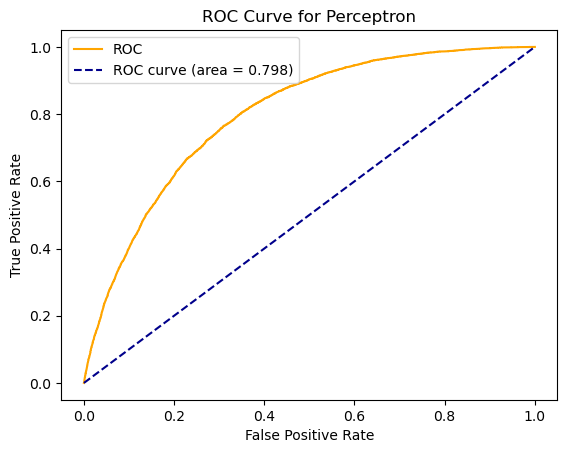

In [9]:
# plot ROC curve
fpr, tpr, thresholds = roc_curve(yTest, yProb_perc)
plt.plot(fpr, tpr, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--',label='ROC curve (area = %0.3f)' % auroc_perc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Perceptron')
plt.legend()
plt.show()

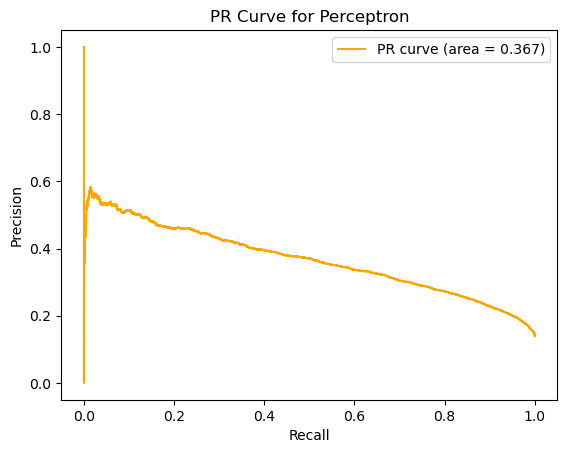

In [10]:
# plot PR curve
prec, rec, thresholds = precision_recall_curve(yTest, yProb_perc)
plt.plot(rec, prec, color='orange', label='PR curve (area = %0.3f)' % auprc_perc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR Curve for Perceptron')
plt.legend()
plt.show()

## Question 2
**Build and train a feedforward neural network with at least one hidden layer to classify
diabetes from the rest of the dataset. Make sure to try different numbers of hidden
layers and different activation functions (at a minimum reLU and sigmoid). Doing so:
How does AUC vary as a function of the number of hidden layers and is it dependent
on the kind of activation function used (make sure to include “no activation function”
in your comparison). How does this network perform relative to the Perceptron?**

* diff # hidden layers
* diff hidden size (# units in layers)
* activation = relu & sigmoid & none
* num epochs
* learning rate
* (X batch size)

In [122]:
# define parameters
learning_rate = 1e-3
num_epochs = 500

D = 20  # dimensions of input - 20 features
C = 2  # num_classes - 2 for diabetes 0/1, 1 for regression
H = 100 # num_hidden_units - try [10, 25, 50, 100] later

# compute class weights for imbalanced classes to pass to criterion/loss function
class_weights = utils.class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(yTrain), y=yTrain.values.flatten())
class_weights = torch.tensor(class_weights, dtype=torch.float32)

# observe training loss - init model with 20 hidden size, not going down at some point
# so model doesn't have enough capacity to improve - increase # of layers or the # of units in layer
# validation is bad but training is good - overfitting, decrease the #

In [96]:
# define neural network models
torch.manual_seed(seed)

# no activation function

# 1 HL
model1_none = nn.Sequential(
    nn.Linear(D, H),
    nn.Linear(H, C)
)

# 2 HL
model2_none = nn.Sequential(
    nn.Linear(D, H),
    nn.Linear(H, H),
    nn.Linear(H, C)
)

# 3 HL
model3_none = nn.Sequential(
    nn.Linear(D, H),
    nn.Linear(H, H),
    nn.Linear(H, H),
    nn.Linear(H, C)
)

# relu as activation function

# 1 HL
model1_relu = nn.Sequential(
    nn.Linear(D, H),
    nn.ReLU(),
    nn.Linear(H, C)
)

# 2 HL
model2_relu = nn.Sequential(
    nn.Linear(D, H),
    nn.ReLU(),
    nn.Linear(H, H),
    nn.ReLU(),
    nn.Linear(H, C)
)

# 3 HL
model3_relu = nn.Sequential(
    nn.Linear(D, H),
    nn.ReLU(),
    nn.Linear(H, H),
    nn.ReLU(),
    nn.Linear(H, H),
    nn.ReLU(),
    nn.Linear(H, C)
)

# sigmoid as activation function

# 1 HL
model1_sig = nn.Sequential(
    nn.Linear(D, H),
    nn.Sigmoid(),
    nn.Linear(H, C)
)

# 2 HL
model2_sig = nn.Sequential(
    nn.Linear(D, H),
    nn.Sigmoid(),
    nn.Linear(H, H),
    nn.Sigmoid(),
    nn.Linear(H, C)
)

# 3 HL
model3_sig = nn.Sequential(
    nn.Linear(D, H),
    nn.Sigmoid(),
    nn.Linear(H, H),
    nn.Sigmoid(),
    nn.Linear(H, H),
    nn.Sigmoid(),
    nn.Linear(H, C)
)

# put all models in a list
q2_models = [model1_none, model2_none, model3_none,
             model1_relu, model2_relu, model3_relu,
             model1_sig, model2_sig, model3_sig]

In [146]:
# use cross entropy loss for classification
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

# define a training loop
def q2_train(model, num_epochs, modelnum):
    
    model.train()
    
    criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
    # stochastic gradient descent optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    
    for e in range(num_epochs):

        # Forward pass over the model to get the logits 
        yPred = model(xTrainT)

        # Compute the loss and accuracy
        loss = criterion(yPred, yTrainT)
        score, predicted = torch.max(yPred, 1)
        acc = (yTrainT == predicted).sum().float() / len(yTrainT)
        auc = roc_auc_score(yTrainT, score.detach().numpy())
        
        print("[MODEL]: %i, [EPOCH]: %i, [LOSS]: %.6f, [ACCURACY]: %.3f, [AUROC]: %.3f" % (modelnum, e, loss.item(), acc, auc))
        display.clear_output(wait=True)

        # reset (zero) the gradients before running the backward pass over the model
        # we need to do this because the gradients get accumulated at the same place across iterations
        optimizer.zero_grad()
        model.zero_grad()

        # Backward pass to compute the gradient of loss wrt our learnable params (weights and biases)
        loss.backward()

        # Update params
        optimizer.step()
        
# define an evaluating function
def q2_test(model, aucs, results):
    
    model.eval()
   
    with torch.no_grad():
        y = torch.max(model(xTestT), 1) 
        yLogit = y.values.detach().numpy() # logits
        yPred = y.indices.numpy() # classes
        
        # logits plugged into auc gives auc, uses them like probabilities
        auroc_m = roc_auc_score(yTest, yLogit)
        auprc_m = average_precision_score(yTest, yLogit)
        acc_m = accuracy_score(yTest, yPred)
        f1_m = f1_score(yTest, yPred)
        
        # print("AUROC = {:0.3f}".format(auroc_m))
        # print("AUPRC = {:0.3f}".format(auprc_m))
        # print("Accuracy = {:0.3f}".format(acc_m))
        # print("F1 Score = {:0.3f}".format(f1_m))
        # print("Confusion matrix:\n", confusion_matrix(yTest, yPred))
        # tn fp / fn tp
        
        # store results
        aucs.append(auroc_m)
        results.append([auprc_m, acc_m, f1_m])

### H = 100 version

In [30]:
q2_auc2 = []
q2_results2 = []

modelnum = 1
for m in q2_models:
    q2_train(m, 200, modelnum)
    q2_test(m, q2_auc2, q2_results2)
    modelnum += 1

[MODEL]: 9, [EPOCH]: 199, [LOSS]: 0.693142, [ACCURACY]: 0.861, [AUROC]: 0.287


Order of networks in results: linear 1,2,3 layers, ReLU 1,2,3 layers, Sigmoid 1,2,3 layers

Order of metrics in results list: AUPRC, accuracy, F1

In [33]:
q2_auc2

[0.5705181542107491,
 0.5660813409273271,
 0.40362576119309673,
 0.5531293346486847,
 0.31535359284593,
 0.42827091197338696,
 0.5007098534533059,
 0.5398373344857857,
 0.28498746750794746]

In [34]:
q2_results2

[[0.21458073056265387, 0.6723431094292022, 0.40098010954165464],
 [0.2211576465560252, 0.6613647114474929, 0.3832872680282853],
 [0.11126530487739782, 0.7360454115421002, 0.3133011998769357],
 [0.1714907720129944, 0.3046160517187007, 0.22995831241678852],
 [0.09576449931474626, 0.29960974456007566, 0.23032770906885572],
 [0.12114413470868682, 0.13932907600126143, 0.24458091860565698],
 [0.154192628387036, 0.8317959634184799, 0.09501590668080594],
 [0.15810793353855632, 0.13932907600126143, 0.24458091860565698],
 [0.09085572943798469, 0.8606709239987386, 0.0]]

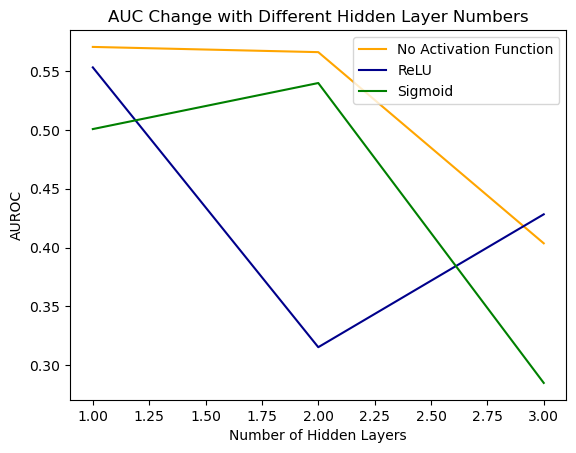

In [35]:
# plot AUC for each hidden layer for each model
plt.figure()
plt.plot(np.arange(1,4), q2_auc2[0:3], color="orange", label="No Activation Function")
plt.plot(np.arange(1,4), q2_auc2[3:6], color="darkblue", label="ReLU")
plt.plot(np.arange(1,4), q2_auc2[6:9], color="green", label="Sigmoid")
plt.title('AUC Change with Different Hidden Layer Numbers')
plt.xlabel('Number of Hidden Layers')
plt.ylabel('AUROC')
plt.legend(loc='upper right')
plt.show()

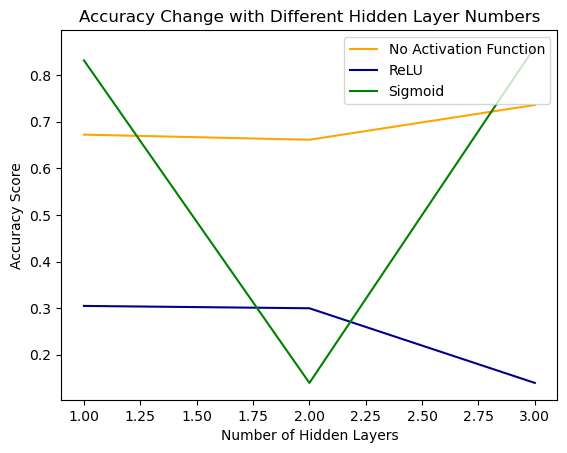

In [36]:
# plot accuracy for each hidden layer for each model
plt.figure()
plt.plot(np.arange(1,4), [q2_results2[0][1],q2_results2[1][1],q2_results2[2][1]], color="orange", label="No Activation Function")
plt.plot(np.arange(1,4), [q2_results2[3][1],q2_results2[4][1],q2_results2[5][1]], color="darkblue", label="ReLU")
plt.plot(np.arange(1,4), [q2_results2[6][1],q2_results2[7][1],q2_results2[8][1]], color="green", label="Sigmoid")
plt.title('Accuracy Change with Different Hidden Layer Numbers')
plt.xlabel('Number of Hidden Layers')
plt.ylabel('Accuracy Score')
plt.legend(loc='upper right')
plt.show()

### H = 50 version

In [188]:
# reinitialize: define neural network models
torch.manual_seed(seed)
H = 50

# no activation function

# 1 HL
model1_none = nn.Sequential(
    nn.Linear(D, H),
    nn.Linear(H, C)
)

# 2 HL
model2_none = nn.Sequential(
    nn.Linear(D, H),
    nn.Linear(H, H),
    nn.Linear(H, C)
)

# 3 HL
model3_none = nn.Sequential(
    nn.Linear(D, H),
    nn.Linear(H, H),
    nn.Linear(H, H),
    nn.Linear(H, C)
)

# relu as activation function

# 1 HL
model1_relu = nn.Sequential(
    nn.Linear(D, H),
    nn.ReLU(),
    nn.Linear(H, C)
)

# 2 HL
model2_relu = nn.Sequential(
    nn.Linear(D, H),
    nn.ReLU(),
    nn.Linear(H, H),
    nn.ReLU(),
    nn.Linear(H, C)
)

# 3 HL
model3_relu = nn.Sequential(
    nn.Linear(D, H),
    nn.ReLU(),
    nn.Linear(H, H),
    nn.ReLU(),
    nn.Linear(H, H),
    nn.ReLU(),
    nn.Linear(H, C)
)

# sigmoid as activation function

# 1 HL
model1_sig = nn.Sequential(
    nn.Linear(D, H),
    nn.Sigmoid(),
    nn.Linear(H, C)
)

# 2 HL
model2_sig = nn.Sequential(
    nn.Linear(D, H),
    nn.Sigmoid(),
    nn.Linear(H, H),
    nn.Sigmoid(),
    nn.Linear(H, C)
)

# 3 HL
model3_sig = nn.Sequential(
    nn.Linear(D, H),
    nn.Sigmoid(),
    nn.Linear(H, H),
    nn.Sigmoid(),
    nn.Linear(H, H),
    nn.Sigmoid(),
    nn.Linear(H, C)
)

# put all models in a list
q2_models = [model1_none, model2_none, model3_none,
             model1_relu, model2_relu, model3_relu,
             model1_sig, model2_sig, model3_sig]

In [37]:
q2_auc3 = []
q2_results3 = []

modelnum = 1
for m in q2_models:
    q2_train(m, 200, modelnum)
    q2_test(m, q2_auc3, q2_results3)
    modelnum += 1

[MODEL]: 9, [EPOCH]: 199, [LOSS]: 0.692954, [ACCURACY]: 0.860, [AUROC]: 0.286


In [38]:
q2_auc3

[0.5493479045263352,
 0.5488058483405753,
 0.42542682668630816,
 0.578820803244509,
 0.3281632357968576,
 0.4490995544628784,
 0.5088590711354771,
 0.3881469896936629,
 0.2843950747335876]

In [39]:
q2_results3

[[0.20761827720325898, 0.6816658782718386, 0.40496628965110704],
 [0.2122944334541401, 0.6731906338694418, 0.3897088593617726],
 [0.12339802931519347, 0.7093976663513087, 0.3567751505104267],
 [0.18514878803913426, 0.43178413749605804, 0.2563520520029922],
 [0.09772105922039698, 0.397153894670451, 0.26259703939437773],
 [0.12831630821800163, 0.13932907600126143, 0.24458091860565698],
 [0.14947181507036314, 0.5453129927467676, 0.23488441511060992],
 [0.10515253727785528, 0.5450764742983286, 0.32442558173569447],
 [0.09077915525911144, 0.8601781772311574, 0.040573437922639975]]

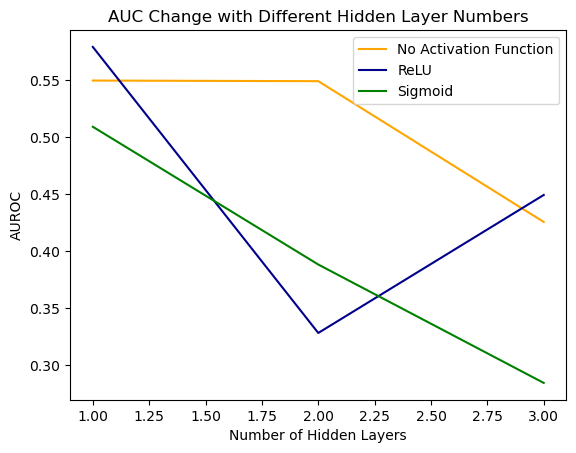

In [40]:
# plot AUC for each hidden layer for each model
plt.figure()
plt.plot(np.arange(1,4), q2_auc3[0:3], color="orange", label="No Activation Function")
plt.plot(np.arange(1,4), q2_auc3[3:6], color="darkblue", label="ReLU")
plt.plot(np.arange(1,4), q2_auc3[6:9], color="green", label="Sigmoid")
plt.title('AUC Change with Different Hidden Layer Numbers')
plt.xlabel('Number of Hidden Layers')
plt.ylabel('AUROC')
plt.legend(loc='upper right')
plt.show()

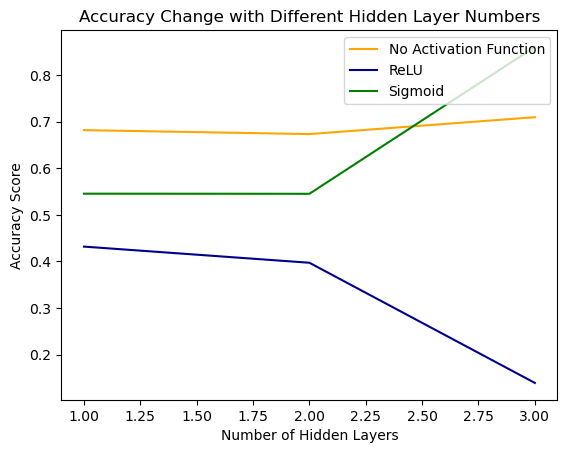

In [42]:
# plot accuracy for each hidden layer for each model
plt.figure()
plt.plot(np.arange(1,4), [q2_results3[0][1],q2_results3[1][1],q2_results3[2][1]], color="orange", label="No Activation Function")
plt.plot(np.arange(1,4), [q2_results3[3][1],q2_results3[4][1],q2_results3[5][1]], color="darkblue", label="ReLU")
plt.plot(np.arange(1,4), [q2_results3[6][1],q2_results3[7][1],q2_results3[8][1]], color="green", label="Sigmoid")
plt.title('Accuracy Change with Different Hidden Layer Numbers')
plt.xlabel('Number of Hidden Layers')
plt.ylabel('Accuracy Score')
plt.legend(loc='upper right')
plt.show()

## Question 3
**Build and train a “deep” network (at least 2 hidden layers) to classify diabetes from
the rest of the dataset. Given the nature of this dataset, is there a benefit of using a
CNN or RNN for the classification?**

There is no benefit of using a CNN or RNN for this classification because we're not trying to capture a pattern or work with data that has a temporal or spatial dimension to it.

### H = 75 

In [160]:
# define deep neural networks
torch.manual_seed(seed)
H = 75

# 2 HL
model2_none = nn.Sequential(
    nn.Linear(D, H),
    nn.Linear(H, H),
    nn.Linear(H, C)
)

# 3 HL
model3_none = nn.Sequential(
    nn.Linear(D, H),
    nn.Linear(H, H),
    nn.Linear(H, H),
    nn.Linear(H, C)
)

q3_models = [model2_none, model3_none]

In [113]:
q3_auc = []
q3_results = []

modelnum = 1
for m in q3_models:
    q2_train(m, 200, modelnum)
    q2_test(m, q3_auc, q3_results)
    modelnum += 1

[MODEL]: 2, [EPOCH]: 199, [LOSS]: 0.692288, [ACCURACY]: 0.148, [AUROC]: 0.677


In [114]:
q3_auc, q3_results

([0.514421644826398, 0.667370381656466],
 [[0.13962222934828405, 0.4669268369599495, 0.3098749681041082],
  [0.26396252354188715, 0.14772548092084517, 0.242568620925222]])

### H = 50

In [186]:
# reinit DNN
torch.manual_seed(seed)
H = 50

# 2 HL
model2_none = nn.Sequential(
    nn.Linear(D, H),
    nn.Linear(H, H),
    nn.Linear(H, C)
)

# 3 HL
model3_none = nn.Sequential(
    nn.Linear(D, H),
    nn.Linear(H, H),
    nn.Linear(H, H),
    nn.Linear(H, C)
)

q3_models = [model2_none, model3_none]

In [124]:
q3_auc3 = []
q3_results3 = []

modelnum = 1
for m in q3_models:
    q2_train(m, 200, modelnum)
    q2_test(m, q3_auc3, q3_results3)
    modelnum += 1

[MODEL]: 2, [EPOCH]: 199, [LOSS]: 0.691904, [ACCURACY]: 0.170, [AUROC]: 0.409


In [125]:
q3_auc3, q3_results3

([0.6695754809148702, 0.417279922064007],
 [[0.24938178116817078, 0.3946113213497319, 0.1253523934276846],
  [0.1153906071322609, 0.1722445600756859, 0.24762177753094827]])

### H = 25

In [187]:
# reinit DNN
torch.manual_seed(seed)
H = 25

# 2 HL
model2_none = nn.Sequential(
    nn.Linear(D, H),
    nn.Linear(H, H),
    nn.Linear(H, C)
)

# 3 HL
model3_none = nn.Sequential(
    nn.Linear(D, H),
    nn.Linear(H, H),
    nn.Linear(H, H),
    nn.Linear(H, C)
)

q3_models = [model2_none, model3_none]

In [161]:
q3_auc4 = []
q3_results4 = []

modelnum = 1
for m in q3_models:
    q2_train(m, 200, modelnum)
    q2_test(m, q3_auc4, q3_results4)
    modelnum += 1

[MODEL]: 2, [EPOCH]: 199, [LOSS]: 0.693857, [ACCURACY]: 0.653, [AUROC]: 0.452


In [162]:
q3_auc4, q3_results4

([0.655554168763498, 0.45368367629235085],
 [[0.22207024337677025, 0.13954588457899716, 0.24460132890365446],
  [0.14275758920164508, 0.6522981709239988, 0.17715378515788982]])

## Question 4
**Build and train a feedforward neural network with one hidden layer to predict BMI
from the rest of the dataset. Use RMSE to assess the accuracy of your model. Does
the RMSE depend on the activation function used?**

### Preprocessing Part 2

In [4]:
# preprocess data in pandas
# separate features from target
dataX2 = data.copy().drop(columns=['BMI'])
dataY2 = pd.DataFrame(data.copy()['BMI'])

In [5]:
# split data into train/test sets 
xTrain2, xTest2, yTrain2, yTest2 = train_test_split(dataX2, dataY2, test_size = 0.2, random_state = 42)
print(xTrain2.shape, xTest2.shape, yTrain2.shape, yTest2.shape)

(202944, 20) (50736, 20) (202944, 1) (50736, 1)


In [6]:
# scale continuous & ordinal features using MinMaxScaler
# so they're between 0 and 1 (as binary variables are 0/1)
# scaling happens after the train/test split to prevent data leakage

contord = ['GeneralHealth', 'AgeBracket', 'EducationBracket', 'IncomeBracket',
            'MentalHealth', 'PhysicalHealth']

scaler = MinMaxScaler()
xTrain2_scaled = scaler.fit_transform(pd.DataFrame(xTrain2[contord]))
for i in range(len(contord)):
    xTrain2[contord[i]] = xTrain2_scaled[:,i]
    
xTest2_scaled = scaler.transform(pd.DataFrame(xTest2[contord]))
for i in range(len(contord)):
    xTest2[contord[i]] = xTest2_scaled[:,i]

In [22]:
# turn dfs to numpy arrays, turn arrays into tensors
xTrainB = torch.tensor(np.array(xTrain2), dtype=torch.float32)
xTestB = torch.tensor(np.array(xTest2), dtype=torch.float32)
yTrainB = torch.flatten(torch.tensor(np.array(yTrain2), dtype=torch.float32))
# yTrainB = yTrainB.long()
yTestB = torch.flatten(torch.tensor(np.array(yTest2), dtype=torch.float32))
# yTestB = yTestB.long()

### Problem

In [65]:
# define 1 hidden layer model with different activation functions
torch.manual_seed(seed)
H = 100
learning_rate = 1e-3

model1_none = nn.Sequential(
    nn.Linear(20, H),
    nn.Linear(H, 1)
)

model1_relu = nn.Sequential(
    nn.Linear(20, H),
    nn.ReLU(),
    nn.Linear(H, 1)
)

model1_sig = nn.Sequential(
    nn.Linear(20, H),
    nn.Sigmoid(),
    nn.Linear(H, 1)
)

q4_models = [model1_none, model1_relu, model1_sig]

In [147]:
# use MSE loss for regression
criterion = torch.nn.MSELoss()

# define a training loop
def q4_train(model, num_epochs, modelnum):
    
    model.train()
    
    # stochastic gradient descent optimizer
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    
    for e in range(num_epochs):

        # Forward pass over the model to get the logits 
        yPred = model(xTrainB).flatten()

        # Compute the loss
        loss = criterion(yPred, yTrainB)
        
        print("[MODEL]: %i, [EPOCH]: %i, [LOSS/MSE]: %.6f" % (modelnum, e, loss.item()))
        display.clear_output(wait=True)

        # reset (zero) the gradients before running the backward pass over the model
        # we need to do this because the gradients get accumulated at the same place across iterations
        optimizer.zero_grad()
        model.zero_grad()

        # Backward pass to compute the gradient of loss wrt our learnable params (weights and biases)
        loss.backward()

        # Update params
        optimizer.step()
        
# define an evaluating function
def q4_test(model, results):
    
    model.eval()
   
    with torch.no_grad():
        yPred = model(xTestB).detach().numpy()
        
        # logits plugged into auc gives auc, uses them like probabilities
        rmse = mean_squared_error(yTest2, yPred, squared=False)
        
        # store results
        results.append(rmse)

#### H = 100, 200 e

In [30]:
q4_results = []

modelnum = 1
for m in q4_models:
    q4_train(m, 200, modelnum)
    q4_test(m, q4_results)
    modelnum += 1

[MODEL]: 3, [EPOCH]: 199, [LOSS/MSE]: 42.753914


In [31]:
q4_results

[7.148145959505741, 7.027571653973327, 6.521466740736697]

#### H = 100, 300 e

In [190]:
# reinit models
torch.manual_seed(seed)
H = 100
learning_rate = 1e-3

model1_none = nn.Sequential(
    nn.Linear(20, H),
    nn.Linear(H, 1)
)

model1_relu = nn.Sequential(
    nn.Linear(20, H),
    nn.ReLU(),
    nn.Linear(H, 1)
)

model1_sig = nn.Sequential(
    nn.Linear(20, H),
    nn.Sigmoid(),
    nn.Linear(H, 1)
)

q4_models = [model1_none, model1_relu, model1_sig]

In [48]:
# H = 100, 300 e
q4_results2 = []

modelnum = 1
for m in q4_models:
    q4_train(m, 300, modelnum)
    q4_test(m, q4_results2)
    modelnum += 1

[MODEL]: 3, [EPOCH]: 299, [LOSS/MSE]: 42.130241


In [49]:
q4_results2

[6.947235023197961, 6.85875284285827, 6.473955708184115]

## Question 5
**Build and train a neural network of your choice to predict BMI from the rest of your
dataset. How low can you get RMSE and what design choices does RMSE seem to
depend on?**

* number of epochs - balance for lower RMSE (too high = increased again)
* learning rate - if increased too much, loss becomes unstable!
* 2 hidden layers brought rmse down a bit compared to 1
* diff hidden size tested below w diff activations: 

In [165]:
# define models 
torch.manual_seed(seed)
H = 100
learning_rate = 1e-3

model1_none = nn.Sequential(
    nn.Linear(20, H),
    nn.Linear(H, H),
    nn.Linear(H, 1)
)

model1_relu = nn.Sequential(
    nn.Linear(20, H),
    nn.ReLU(),
    nn.Linear(H, H),
    nn.ReLU(),
    nn.Linear(H, 1)
)

model1_sig = nn.Sequential(
    nn.Linear(20, H),
    nn.Sigmoid(),
    nn.Linear(H, H),
    nn.Sigmoid(),
    nn.Linear(H, 1) 
)

q5_models = [model1_none, model1_relu, model1_sig]

In [166]:
# H=100, 300 e more layers
q5_results0 = []

modelnum = 1
for m in q5_models:
    q4_train(m, 300, modelnum)
    q4_test(m, q5_results0)
    modelnum += 1

[MODEL]: 3, [EPOCH]: 299, [LOSS/MSE]: 43.523022


In [167]:
q5_results0

[6.474085539246689, 6.431755478815381, 6.578634842800645]

In [87]:
# H=50, 300 e more layers
torch.manual_seed(seed)
H = 50
learning_rate = 1e-3

model1_none = nn.Sequential(
    nn.Linear(20, H),
    nn.Linear(H, H),
    nn.Linear(H, 1)
)

model1_relu = nn.Sequential(
    nn.Linear(20, H),
    nn.ReLU(),
    nn.Linear(H, H),
    nn.ReLU(),
    nn.Linear(H, 1)
)

model1_sig = nn.Sequential(
    nn.Linear(20, H),
    nn.Sigmoid(),
    nn.Linear(H, H),
    nn.Sigmoid(),
    nn.Linear(H, 1) 
)

q5_models = [model1_none, model1_relu, model1_sig]

q5_results = []

modelnum = 1
for m in q5_models:
    q4_train(m, 300, modelnum)
    q4_test(m, q5_results)
    modelnum += 1

[MODEL]: 3, [EPOCH]: 299, [LOSS/MSE]: 43.480774


In [88]:
q5_results
#[6.474085539246689, 6.431755478815381, 6.578634842800645]

[6.4732912109560665, 6.448369151569148, 6.575143817601382]

In [84]:
# H=50, 200 e more layers
torch.manual_seed(seed)
H = 50
learning_rate = 1e-3

model1_none = nn.Sequential(
    nn.Linear(20, H),
    nn.Linear(H, H),
    nn.Linear(H, 1)
)

model1_relu = nn.Sequential(
    nn.Linear(20, H),
    nn.ReLU(),
    nn.Linear(H, H),
    nn.ReLU(),
    nn.Linear(H, 1)
)

model1_sig = nn.Sequential(
    nn.Linear(20, H),
    nn.Sigmoid(),
    nn.Linear(H, H),
    nn.Sigmoid(),
    nn.Linear(H, 1) 
)

q5_results2 = []

modelnum = 1
for m in q5_models:
    q4_train(m, 200, modelnum)
    q4_test(m, q5_results2)
    modelnum += 1
#[MODEL]: 3, [EPOCH]: 199, [LOSS/MSE]: 43.303879

[MODEL]: 3, [EPOCH]: 199, [LOSS/MSE]: 43.625771


In [85]:
q5_results2
#[6.262104686596941, 6.24537284281639, 6.562027933847368]

[6.653333920132557, 6.610342621259697, 6.5860902472243765]

In [72]:
# H=100, 200 e more layers
torch.manual_seed(seed)
H = 100
learning_rate = 1e-3

model1_none = nn.Sequential(
    nn.Linear(20, H),
    nn.Linear(H, H),
    nn.Linear(H, 1)
)

model1_relu = nn.Sequential(
    nn.Linear(20, H),
    nn.ReLU(),
    nn.Linear(H, H),
    nn.ReLU(),
    nn.Linear(H, 1)
)

model1_sig = nn.Sequential(
    nn.Linear(20, H),
    nn.Sigmoid(),
    nn.Linear(H, H),
    nn.Sigmoid(),
    nn.Linear(H, 1) 
)

q5_results3 = []

modelnum = 1
for m in q5_models:
    q4_train(m, 200, modelnum)
    q4_test(m, q5_results3)
    modelnum += 1

[MODEL]: 3, [EPOCH]: 199, [LOSS/MSE]: 43.634438


In [73]:
q5_results3

[6.666888330919462, 6.601179124761885, 6.587064394547919]

In [78]:
# H=75, 200 e more layers
torch.manual_seed(seed)
H = 75
learning_rate = 1e-3

model1_none = nn.Sequential(
    nn.Linear(20, H),
    nn.Linear(H, H),
    nn.Linear(H, 1)
)

model1_relu = nn.Sequential(
    nn.Linear(20, H),
    nn.ReLU(),
    nn.Linear(H, H),
    nn.ReLU(),
    nn.Linear(H, 1)
)

model1_sig = nn.Sequential(
    nn.Linear(20, H),
    nn.Sigmoid(),
    nn.Linear(H, H),
    nn.Sigmoid(),
    nn.Linear(H, 1) 
)

q5_results4 = []

modelnum = 1
for m in q5_models:
    q4_train(m, 200, modelnum)
    q4_test(m, q5_results4)
    modelnum += 1

[MODEL]: 3, [EPOCH]: 199, [LOSS/MSE]: 43.472504


In [79]:
q5_results4

[6.657647354584873, 6.616655170694267, 6.575047882438081]

In [81]:
# H=25, 200 e more layers
torch.manual_seed(seed)
H = 25
learning_rate = 1e-3

model1_none = nn.Sequential(
    nn.Linear(20, H),
    nn.Linear(H, H),
    nn.Linear(H, 1)
)

model1_relu = nn.Sequential(
    nn.Linear(20, H),
    nn.ReLU(),
    nn.Linear(H, H),
    nn.ReLU(),
    nn.Linear(H, 1)
)

model1_sig = nn.Sequential(
    nn.Linear(20, H),
    nn.Sigmoid(),
    nn.Linear(H, H),
    nn.Sigmoid(),
    nn.Linear(H, 1) 
)

q5_results5 = []

modelnum = 1
for m in q5_models:
    q4_train(m, 200, modelnum)
    q4_test(m, q5_results5)
    modelnum += 1

[MODEL]: 3, [EPOCH]: 199, [LOSS/MSE]: 43.387024


In [82]:
q5_results5

[6.609998672314062, 6.653731050707734, 6.568421090937007]

In [89]:
# define models 
torch.manual_seed(seed)
H = 100
learning_rate = 1e-3

model1_none = nn.Sequential(
    nn.Linear(20, H),
    nn.Linear(H, H),
    nn.Linear(H, 1)
)

# H=100, 300 e more layers w no activation
q5_results6 = []

q4_train(model1_none, 300, 1)
q4_test(model1_none, q5_results6)

[MODEL]: 1, [EPOCH]: 299, [LOSS/MSE]: 41.995518


In [90]:
q5_results6

[6.474085539246689]

In [95]:
# define models 
torch.manual_seed(seed)
H = 50
learning_rate = 1e-3

model1_relu = nn.Sequential(
    nn.Linear(20, H),
    nn.ReLU(),
    nn.Linear(H, H),
    nn.ReLU(),
    nn.Linear(H, 1)
)

# H=50, 300 e more layers w relu
q5_results7 = []

q4_train(model1_relu, 300, 1)
q4_test(model1_relu, q5_results7)

[MODEL]: 1, [EPOCH]: 299, [LOSS/MSE]: 41.955467


In [96]:
q5_results7

[6.4729466581616455]

In [99]:
# define models 
torch.manual_seed(seed)
H = 50
learning_rate = 0.002

model1_relu = nn.Sequential(
    nn.Linear(20, H),
    nn.ReLU(),
    nn.Linear(H, H),
    nn.ReLU(),
    nn.Linear(H, 1)
)

# H=50, 200 e more layers w relu, 0.002 lr
q5_results8 = []

q4_train(model1_relu, 200, 1)
q4_test(model1_relu, q5_results8)

[MODEL]: 1, [EPOCH]: 199, [LOSS/MSE]: 40.570930


In [100]:
q5_results8

[6.362380804479654]

In [102]:
# define models 
torch.manual_seed(seed)
H = 50
learning_rate = 0.002

model1_relu = nn.Sequential(
    nn.Linear(20, H),
    nn.ReLU(),
    nn.Linear(H, H),
    nn.ReLU(),
    nn.Linear(H, 1)
)

# H=50, 250 e more layers w relu, 0.002 lr
q5_results9 = []

q4_train(model1_relu, 250, 1)
q4_test(model1_relu, q5_results9)

[MODEL]: 1, [EPOCH]: 249, [LOSS/MSE]: 39.602802


In [103]:
q5_results9

[6.284144126730596]

In [104]:
# define models 
torch.manual_seed(seed)
H = 50
learning_rate = 0.002

model1_relu = nn.Sequential(
    nn.Linear(20, H),
    nn.ReLU(),
    nn.Linear(H, H),
    nn.ReLU(),
    nn.Linear(H, 1)
)

# H=50, 300 e more layers w relu, 0.002 lr
q5_results10 = []

q4_train(model1_relu, 300, 1)
q4_test(model1_relu, q5_results10)

[MODEL]: 1, [EPOCH]: 299, [LOSS/MSE]: 38.925385


In [105]:
q5_results10 # increasing to 500 epochs increased result

[6.228678300495256]

In [108]:
# define models 
torch.manual_seed(seed)
H = 50
learning_rate = 0.002

model1_relu = nn.Sequential(
    nn.Linear(20, H),
    nn.ReLU(),
    nn.Linear(H, H),
    nn.ReLU(),
    nn.Linear(H, H),
    nn.ReLU(),
    nn.Linear(H, 1)
)

# H=50, 200 e, 3 layers w relu, 0.002 lr
q5_results11 = []

q4_train(model1_relu, 200, 1)
q4_test(model1_relu, q5_results11)

[MODEL]: 1, [EPOCH]: 199, [LOSS/MSE]: 38.297398


In [109]:
q5_results11

[6.1792510921081325]

In [172]:
# define models 
torch.manual_seed(seed)
H = 100
learning_rate = 0.002

model1_relu = nn.Sequential(
    nn.Linear(20, H),
    nn.Sigmoid(),
    nn.Linear(H, H),
    nn.Sigmoid(),
    nn.Linear(H, 1)
)

# H=50, 300 e, 3 layers w sigmoid, 0.002 lr
q5_results13 = []

q4_train(model1_relu, 300, 1)
q4_test(model1_relu, q5_results13)

[MODEL]: 1, [EPOCH]: 299, [LOSS/MSE]: 43.141232


In [173]:
q5_results13
# [6.588174001529347] with extra layer, 50
# [6.530419231965142] with 50

[6.550047427390426]

### Final Model

In [111]:
# define models 
torch.manual_seed(seed)
H = 50
learning_rate = 0.002

model1_relu = nn.Sequential(
    nn.Linear(20, H),
    nn.ReLU(),
    nn.Linear(H, H),
    nn.ReLU(),
    nn.Linear(H, H),
    nn.ReLU(),
    nn.Linear(H, 1)
)

# H=50, 300 e, 3 layers w relu, 0.002 lr
q5_results12 = []

q4_train(model1_relu, 300, 1)
q4_test(model1_relu, q5_results12)

[MODEL]: 1, [EPOCH]: 299, [LOSS/MSE]: 37.791744


In [112]:
q5_results12

[6.135516699813233]

## Extra Credit: Part A
Are there any predictors/features that have effectively no impact on the accuracy of these
models? If so, please list them and comment briefly on your findings.

### Diabetes model

In [138]:
# first best model - for diabetes classification

# 2 HL
torch.manual_seed(seed)
H = 50
learning_rate = 0.001

best_q3 = nn.Sequential(
    nn.Linear(20, H),
    nn.Linear(H, H),
    nn.Linear(H, 2)
)

eca_auc = []
eca_results = []

q2_train(best_q3, 200, modelnum)
q2_test(best_q3, eca_auc, eca_results)

[MODEL]: 1, [EPOCH]: 199, [LOSS]: 0.714416, [ACCURACY]: 0.393, [AUROC]: 0.668


In [139]:
eca_auc, eca_results

([0.6695754809148702],
 [[0.24938178116817078, 0.3946113213497319, 0.1253523934276846]])

In [141]:
bestauc = eca_auc[0]
bestacc = eca_results[0][1]

In [142]:
m1_aucdiff = []
m1_accdiff = []

for col in xTest.columns:
    xTest_copy = xTest.copy()
    xTest_copy[col] = xTest[col].sample(frac=1).values
    xTest_copy = torch.tensor(np.array(xTest_copy), dtype=torch.float32)
    
    y = torch.max(best_q3(xTest_copy), 1) 
    yLogit = y.values.detach().numpy() # logits
    yPred = y.indices.numpy() # classes
    
    auc = roc_auc_score(yTest, yLogit)
    acc = accuracy_score(yTest, yPred)
    # rmse = mean_squared_error(best_q3(model.blah)
    
    m1_aucdiff.append({'predictor':col, 'score':auc-bestauc})
    m1_accdiff.append({'predictor':col, 'score':acc-bestacc})

In [176]:
m1_auc = pd.DataFrame(m1_aucdiff).sort_values(by='score', ascending=True, key=abs)
m1_acc = pd.DataFrame(m1_accdiff).sort_values(by='score', ascending=True, key=abs)

In [182]:
m1_auc.head(10)

,predictor,score
12,GeneralHealth,-0.000400
18,EducationBracket,-0.000417
11,NotAbleToAffordDoctor,-0.001398
16,BiologicalSex,-0.001662
2,BMI,-0.001821
7,Fruit,-0.001838
13,MentalHealth,-0.003546
10,HasHealthcare,0.004066
4,Stroke,-0.005539
3,Smoker,-0.005874


In [180]:
m1_acc.head(10)

,predictor,score
17,AgeBracket,-0.000355
11,NotAbleToAffordDoctor,-0.000729
10,HasHealthcare,-0.000788
18,EducationBracket,0.001104
9,HeavyDrinker,0.001537
2,BMI,-0.002405
16,BiologicalSex,-0.003272
3,Smoker,0.004592
6,PhysActivity,-0.007569
4,Stroke,0.008219


### BMI model

In [149]:
# second best model - for bmi prediction
torch.manual_seed(seed)
H = 50
learning_rate = 0.002

model1_relu = nn.Sequential(
    nn.Linear(20, H),
    nn.ReLU(),
    nn.Linear(H, H),
    nn.ReLU(),
    nn.Linear(H, H),
    nn.ReLU(),
    nn.Linear(H, 1)
)

# H=100, 300 e, 3 layers w no activation, 0.002 lr
ecb_results = []

q4_train(model1_relu, 300, 1)
q4_test(model1_relu, ecb_results)

[MODEL]: 1, [EPOCH]: 299, [LOSS/MSE]: 37.791744


In [151]:
bestrmse = ecb_results[0]
ecb_results

[6.135516699813233]

In [156]:
m2_rmsediff = []

for col in xTest2.columns:
    xTest2_copy = xTest2.copy()
    xTest2_copy[col] = xTest2[col].sample(frac=1).values
    xTest2_copy = torch.tensor(np.array(xTest2_copy), dtype=torch.float32)
    
    yPred = model1_relu(xTest2_copy).detach().numpy()
    rmse = mean_squared_error(yTest2, yPred, squared=False)
    
    m2_rmsediff.append({'predictor':col, 'score':rmse-bestrmse})


In [185]:
m2_rmse = pd.DataFrame(m2_rmsediff).sort_values(by='score', ascending=True)
m2_rmse.head(5)

,predictor,score
8,Vegetables,0.000400
13,MentalHealth,0.000531
10,HasHealthcare,0.000547
18,EducationBracket,0.000696
11,NotAbleToAffordDoctor,0.004869


## Extra Credit: Part B
Write a summary statement on the overall pros and cons of using neural networks to
learn from the same dataset as in the prior homework, relative to using classical methods
(logistic regression, SVM, trees, forests, boosting methods). Any overall lessons?

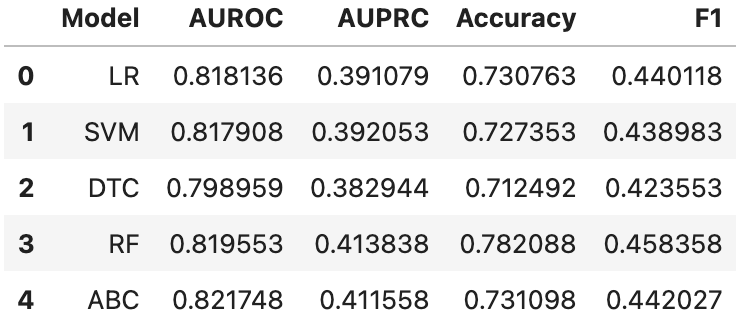

* NNs are great for modeling more complex relationships, but they may be too complex for certain relationships that would be better modeled by linear methods.
* This dataset is large, but not very large - different seeds and network initializations do make differences. Classical methods are better suited for smaller datasets, since it takes a lot of data to train all the parameters of a  neural network well. NNs can perform poorly if not trained on enough data.
* NNs require much more hyperparameter tuning to really optimize their performance. NNs already take so much time to train individually, so retraining or validating models take that much more time and effort. It took significantly more time to complete this assignment than the previous one using the same data.
* From performance in the previous assignment compared to this one, it appears a simpler model may be better for classifying diabetes with this particular dataset - the perceptron had the most similar performance to the classical methods, and my NNs performed worse even after attempting to hyperparameter tune
* I can't compare the performance for the regression task (predicting BMI) since that was not done in the previous assignment, but using NNs to do regression using this dataset seemed more fitting than the classification task